In [1]:
# Install necessary packages
!pip install transformers sentencepiece torch torchvision albumentations timm


In [2]:
# Import required libraries
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
import numpy as np
import pandas as pd
import itertools
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import cv2
import timm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:

# Step 1: Mount Google Drive to access the dataset.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Define paths to the image folder and caption file
image_folder = '/content/drive/MyDrive/Bangla Image dataset with caption/BNATURE/Pictures'
caption_file = '/content/drive/MyDrive/Bangla Image dataset with caption/BNATURE/caption/captions.json'


In [18]:
# Define configuration with adjusted batch size
class CFG:
    model_name = "resnet50"
    text_encoder_model = "sagorsarker/bangla-bert-base"  # Bangla BERT model
    pretrained = True
    trainable = True
    batch_size = 16  # Reduced batch size
    size = 224
    image_embedding = 2048
    text_embedding = 768
    projection_dim = 512
    max_length = 128
    temperature = 0.07
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    head_lr = 1e-3
    weight_decay = 1e-4
    patience = 2
    factor = 0.5
    device = "cuda" if torch.cuda.is_available() else "cpu"
    epochs = 7


In [19]:
# Dataset class
class CLIPDataset(Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        image = cv2.imread(f"{image_folder}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]
        return item

    def __len__(self):
        return len(self.captions)

In [20]:

# Image Encoder
class ImageEncoder(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained, num_classes=0, global_pool="avg")
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [21]:
# Text Encoder
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        for p in self.model.parameters():
            p.requires_grad = trainable
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [22]:
# Projection Head
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim=CFG.projection_dim, dropout=0.1):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [23]:

# CLIP Model
class CLIPModel(nn.Module):
    def __init__(self, temperature=CFG.temperature):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=CFG.image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=CFG.text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax((images_similarity + texts_similarity) / 2 * self.temperature, dim=-1)
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss = (images_loss + texts_loss) / 2.0
        return loss.mean()

In [24]:

# Cross Entropy
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    return loss.mean() if reduction == "mean" else loss

# Data loaders
def get_transforms():
    return A.Compose([
        A.Resize(CFG.size, CFG.size, always_apply=True),
        A.Normalize(max_pixel_value=255.0, always_apply=True),
    ])

In [25]:
with open(caption_file, 'r', encoding='utf-8') as f:
    captions_data = json.load(f)

# Print a sample item to inspect the structure
print(captions_data[0])  # Check the first item for key names


{'caption_id': '1.jpg', 'bengali_caption': '  গ্রামে হাঁটা দুই শিশু।'}


In [26]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Add this line for functional operations
import albumentations as A
import numpy as np
import pandas as pd
import itertools
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import cv2
import timm


In [27]:
import torch
from tqdm import tqdm

# Validation function for the model
def valid_epoch(model, valid_loader):
    model.eval()  # Set the model to evaluation mode
    loss_meter = 0
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(valid_loader, total=len(valid_loader)):
            batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}

            # No need for mixed precision during validation
            loss = model(batch)

            loss_meter += loss.item()

    # Return the average loss
    return loss_meter / len(valid_loader)


In [28]:

# Optimized train_epoch with mixed precision
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    model.train()
    scaler = torch.cuda.amp.GradScaler()  # Mixed precision scaler
    loss_meter = 0
    for batch in tqdm(train_loader, total=len(train_loader)):
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}

        with torch.cuda.amp.autocast():  # Mixed precision training
            loss = model(batch)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if step == "batch":
            lr_scheduler.step()

        loss_meter += loss.item()
    return loss_meter / len(train_loader)

# Validation function remains the same

# Main function with optimizations for data loading and mixed precision training
def main():
    with open(caption_file, 'r', encoding='utf-8') as f:
        captions_data = json.load(f)

    # Extract image files and captions based on provided structure
    image_files = [item['caption_id'].split('#')[0] for item in captions_data]
    captions = [item['bengali_caption'] for item in captions_data]

    tokenizer = AutoTokenizer.from_pretrained(CFG.text_encoder_model)
    transforms = get_transforms()
    dataset = CLIPDataset(image_files, captions, tokenizer, transforms)

    # Data splitting into train and validation sets
    train_size = int(0.8 * len(dataset))
    valid_size = len(dataset) - train_size
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

    # DataLoader with num_workers for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=4)

    model = CLIPModel().to(CFG.device)

    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(model.image_projection.parameters(), model.text_projection.parameters()),
         "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]

    optimizer = torch.optim.AdamW(params, weight_decay=0.0)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=CFG.patience, factor=CFG.factor)
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch {epoch + 1}/{CFG.epochs}")

        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        print(f"Train Loss: {train_loss:.4f}")

        valid_loss = valid_epoch(model, valid_loader)
        print(f"Validation Loss: {valid_loss:.4f}")

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), "best_clip_model_bangla.pt")
            print("Best model saved!")

        if step == "epoch":
            lr_scheduler.step(valid_loss)

# Run the training with optimizations
main()

<ipython-input-28-7371df4d553e>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision scaler


Epoch 1/7


  0%|          | 0/1956 [00:00<?, ?it/s]<ipython-input-28-7371df4d553e>:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision training
100%|██████████| 1956/1956 [08:13<00:00,  3.96it/s]


Train Loss: 26.2047


100%|██████████| 489/489 [01:17<00:00,  6.29it/s]


Validation Loss: 2.8797
Best model saved!
Epoch 2/7


100%|██████████| 1956/1956 [08:05<00:00,  4.03it/s]


Train Loss: 3.3960


100%|██████████| 489/489 [01:17<00:00,  6.35it/s]


Validation Loss: 2.8011
Best model saved!
Epoch 3/7


100%|██████████| 1956/1956 [08:08<00:00,  4.00it/s]


Train Loss: 2.9436


100%|██████████| 489/489 [01:18<00:00,  6.23it/s]


Validation Loss: 2.7795
Best model saved!
Epoch 4/7


100%|██████████| 1956/1956 [08:06<00:00,  4.02it/s]


Train Loss: 2.8858


100%|██████████| 489/489 [01:15<00:00,  6.47it/s]


Validation Loss: 2.7775
Best model saved!
Epoch 5/7


100%|██████████| 1956/1956 [08:10<00:00,  3.99it/s]


Train Loss: 2.7000


100%|██████████| 489/489 [01:15<00:00,  6.45it/s]


Validation Loss: 2.7768
Best model saved!
Epoch 6/7


100%|██████████| 1956/1956 [08:07<00:00,  4.01it/s]


Train Loss: 1.7529


100%|██████████| 489/489 [01:17<00:00,  6.32it/s]


Validation Loss: 1.5386
Best model saved!
Epoch 7/7


100%|██████████| 1956/1956 [08:18<00:00,  3.92it/s]


Train Loss: 1.6344


100%|██████████| 489/489 [01:18<00:00,  6.20it/s]


Validation Loss: 1.4690
Best model saved!


#Interface

In [29]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from tqdm import tqdm

# Assuming CLIPDataset and CFG have already been defined
# Ensure the paths to the dataset are properly set

# Load and prepare the dataset
with open(caption_file, 'r', encoding='utf-8') as f:
    captions_data = json.load(f)

# Prepare image files and captions
image_files = [item['caption_id'].split('#')[0] for item in captions_data]
captions = [item['bengali_caption'] for item in captions_data]

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(CFG.text_encoder_model)
transforms = get_transforms()

# Create the dataset
dataset = CLIPDataset(image_files, captions, tokenizer, transforms)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
_, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Define the function to get image embeddings
def get_image_embeddings(valid_dataset, model_path):
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=4)

    # Load the trained model
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)

    return model, torch.cat(valid_image_embeddings)

# Perform inference to get image embeddings from the validation set
model, image_embeddings = get_image_embeddings(valid_dataset, "/content/best_clip_model_bangla.pt")


<ipython-input-29-5cd1d8d9c57e>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=CFG.device))
100%|██████████| 489

In [35]:
import matplotlib.pyplot as plt  # Add this import


In [36]:
def find_matches(model, image_embeddings, query, image_files, n=9):
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_encoder_model)

    # Encode the query and print to ensure uniqueness
    encoded_query = tokenizer([query], return_tensors="pt", padding=True, truncation=True, max_length=CFG.max_length)
    print(f"Encoded Query: {encoded_query}")  # Check if different prompts yield different encodings

    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }

    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    # Normalize embeddings and print for debugging
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)

    print(f"Text Embeddings: {text_embeddings_n}")  # Check if text embeddings change with different prompts

    # Calculate similarity and retrieve top matches
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    values, indices = torch.topk(dot_similarity.squeeze(0), n)

    matches = [image_files[idx] for idx in indices]
    print(f"Top match values: {values}")  # To see if similarity scores vary

    # Display the matched images
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{image_folder}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

Encoded Query: {'input_ids': tensor([[  101, 21697,  2046,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
Text Embeddings: tensor([[ 1.2782e-02, -8.4525e-03, -1.4704e-02,  3.6222e-02,  4.0286e-02,
         -4.2494e-03,  5.4241e-04, -4.5076e-02,  7.3957e-03,  1.6515e-03,
          1.8421e-03,  2.2220e-02,  3.2071e-02,  1.2411e-02,  1.8340e-02,
          3.1918e-03,  6.3195e-02,  5.4014e-03, -1.7140e-02,  2.3290e-02,
          6.8663e-03,  1.1958e-03,  6.6481e-03,  3.6118e-02, -3.0461e-04,
          1.0348e-02,  4.4071e-04,  7.9066e-03,  2.2623e-02,  1.1433e-02,
          1.2528e-02, -3.0911e-02, -2.1221e-02,  1.6699e-03, -9.5175e-03,
          1.5075e-01,  1.8079e-02, -3.2355e-03,  1.7220e-03, -4.1025e-03,
          1.3151e-02,  3.3837e-02,  2.5032e-02,  8.0099e-03, -2.9533e-03,
          2.5236e-02,  1.7579e-02, -1.0454e-02,  3.2387e-02,  4.9377e-03,
          3.6842e-02,  1.6366e-02,  1.6933e-02, -3.1486e-02,  5.1889e-02,
          1.9856

<ipython-input-36-ed6b4e77c0c2>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values).to(CFG.device)


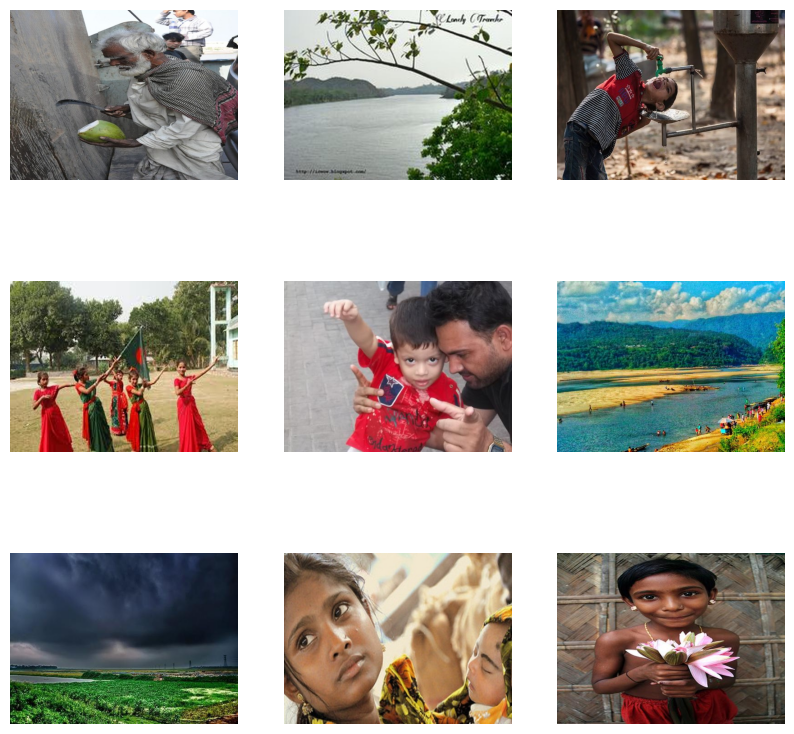

In [39]:
prompt = "কুকুর "  # Example prompt for "A dog is playing"
find_matches(model, image_embeddings, prompt, image_files)


In [38]:
from google.colab import files

# Path to your saved model file
model_path = "best_clip_model_bangla.pt"  # Replace with your actual model file name if different

# Download the file
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>